In [1]:
import os
import random
SEED_NUMBER = 1998

random.seed(SEED_NUMBER)

def parse_annotation(annotation_file_path, shuffle=False):
    with open(annotation_file_path, "rt") as file:
        lines = [line.replace("\n", "") for line in file.readlines()]
        image_label = [[line.split(" ")[0], line.split(" ")[2]] for line in lines]
    if shuffle:
        random.shuffle(image_label)
    return image_label


TRAINVAL_ANNOTATION_TXT = os.path.join(
    "dataset", "pet", "annotations", "trainval.txt"
)
trainval_label = parse_annotation(TRAINVAL_ANNOTATION_TXT, shuffle=True)
trainval_label

[['miniature_pinscher_119', '2'],
 ['chihuahua_164', '2'],
 ['Russian_Blue_139', '1'],
 ['basset_hound_172', '2'],
 ['english_setter_158', '2'],
 ['Russian_Blue_16', '1'],
 ['german_shorthaired_167', '2'],
 ['miniature_pinscher_151', '2'],
 ['german_shorthaired_119', '2'],
 ['miniature_pinscher_188', '2'],
 ['saint_bernard_100', '2'],
 ['german_shorthaired_170', '2'],
 ['Ragdoll_159', '1'],
 ['english_setter_137', '2'],
 ['Maine_Coon_205', '1'],
 ['leonberger_155', '2'],
 ['english_cocker_spaniel_102', '2'],
 ['British_Shorthair_163', '1'],
 ['British_Shorthair_114', '1'],
 ['pomeranian_168', '2'],
 ['Ragdoll_190', '1'],
 ['great_pyrenees_100', '2'],
 ['american_pit_bull_terrier_187', '2'],
 ['japanese_chin_108', '2'],
 ['Ragdoll_174', '1'],
 ['english_setter_153', '2'],
 ['Egyptian_Mau_155', '1'],
 ['Sphynx_125', '1'],
 ['Bombay_13', '1'],
 ['german_shorthaired_179', '2'],
 ['boxer_179', '2'],
 ['scottish_terrier_119', '2'],
 ['german_shorthaired_160', '2'],
 ['great_pyrenees_173', '2

In [2]:
boundary = int(len(trainval_label) * 0.8)
train_label = trainval_label[:boundary]
validation_label = trainval_label[boundary:]
print(len(trainval_label))
print(len(train_label))
print(len(validation_label))

3680
2944
736


data.shape (200, 200, 3)
label.shape (200, 200)
1    28871
0     6402
2     4727
dtype: int64
1


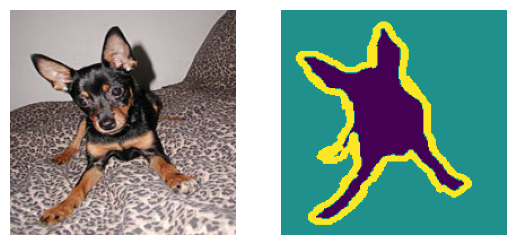

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


ANNOTATION_DIR = os.path.join("dataset", "pet", "annotations", "trimaps")
TRAIN_DIR = os.path.join("dataset", "pet", "images")
ANNOTATION_EXTENSION = ".png"
TRAIN_EXTENSION = ".jpg"
IMAGE_SIZE = (200, 200)


def image_dataset_generator(filename_to_label):
    for filename, label in filename_to_label:
        yield (
            np.asarray(
                Image.open(os.path.join(TRAIN_DIR, filename + TRAIN_EXTENSION))
                .resize(IMAGE_SIZE)
                .convert("RGB")
            ),
            (np.asarray(
                Image.open(
                    os.path.join(ANNOTATION_DIR, filename + ANNOTATION_EXTENSION)
                ).resize(IMAGE_SIZE)
            )
            - 1, int(label)-1),
        )


import pandas as pd


for data, labels in image_dataset_generator(trainval_label):
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(data)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(labels[0])
    print("data.shape", data.shape)
    print("label.shape", labels[0].shape)
    print(pd.Series(labels[0].flatten()).value_counts())
    print(labels[1])
    break


In [4]:
import tensorflow as tf
import numpy as np

def get_dataset(filename_to_label, output_signature):
    return tf.data.Dataset.from_generator(
        lambda :image_dataset_generator(filename_to_label),
        output_signature=output_signature,
    )

output_signature = (
    tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    (tf.TensorSpec(shape=IMAGE_SIZE, dtype=tf.int32), tf.TensorSpec(shape=None, dtype=tf.int32)),
)


train_dataset = get_dataset(
    train_label, output_signature
)
validation_dataset = get_dataset(
    validation_label, output_signature
)
train_dataset


2022-10-26 14:03:06.167376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 14:03:06.350836: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 14:03:07.057955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-26 14:03:07.058057: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<FlatMapDataset element_spec=(TensorSpec(shape=(200, 200, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(200, 200), dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)))>

In [5]:
def get_xception_model(image_size):
    model_in = tf.keras.Input((*image_size, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(model_in)
    x = tf.keras.layers.Conv2D(32, 5, padding="same", use_bias=False)(x)
    # Encoding stage
    block_in = x
    for channel in [32, 64, 128]:
        x = tf.keras.layers.BatchNormalization()(block_in)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.SeparableConv2D(channel, 3, padding="same", use_bias=False)(x)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.SeparableConv2D(channel, 3, padding="same", use_bias=False)(x)
        
        x = tf.keras.layers.MaxPool2D(3, strides=2, padding="same")(x)
        
        y = tf.keras.layers.Conv2D(channel, 1, strides=2, padding="same", use_bias=False)(block_in)
        block_out = tf.keras.layers.Add()([x, y])

        block_in = block_out
    enc_out = block_out
    # Decoding stage
    block_in = enc_out
    for channel in [256, 128, 64]:
        x = tf.keras.layers.BatchNormalization()(block_in)
        x = tf.keras.layers.ReLU()(x)
        block_out = tf.keras.layers.Conv2DTranspose(channel, 3, strides=2, padding="same", use_bias=False)(x)
        
        block_in = block_out
    dec_out = block_out
    # Segmentation stage
    seg_out = tf.keras.layers.Conv2D(3, 3, padding="same", activation="softmax", name="seg")(dec_out)
    # Classification stage
    x = tf.keras.layers.GlobalAvgPool2D()(enc_out)
    x = tf.keras.layers.Dropout(0.5)(x)
    clf_out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    # Return Model
    return tf.keras.Model(inputs=[model_in], outputs=[seg_out, clf_out], name="Xception")

model = get_xception_model(IMAGE_SIZE)
model.summary()
        

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  2400        ['rescaling[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=[
        tf.keras.losses.SparseCategoricalCrossentropy(),
        tf.keras.losses.BinaryCrossentropy(),
    ],
    loss_weights=[0.9, 0.1],
    metrics=[[], [tf.keras.metrics.BinaryAccuracy()]]
)


In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("", save_best_only=True)
]

In [8]:
history = model.fit(
    train_dataset.shuffle(4096).repeat(1).batch(32),
    epochs=70,
    validation_data=validation_dataset.repeat(1).batch(32),
    callbacks=callbacks
)


Epoch 1/70


2022-10-26 14:03:22.831887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1374 of 4096
2022-10-26 14:03:32.823835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2628 of 4096
2022-10-26 14:03:35.235370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-26 14:03:35.768127: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-26 14:03:36.282762: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


     92/Unknown - 42s 151ms/step - loss: 0.7600 - seg_loss: 0.7749 - dense_loss: 0.6266 - dense_binary_accuracy: 0.6675

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 54s 283ms/step - loss: 0.7600 - seg_loss: 0.7749 - dense_loss: 0.6266 - dense_binary_accuracy: 0.6675 - val_loss: 0.8975 - val_seg_loss: 0.9206 - val_dense_loss: 0.6894 - val_dense_binary_accuracy: 0.6916
Epoch 2/70


2022-10-26 14:04:14.155980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1313 of 4096
2022-10-26 14:04:24.155832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2602 of 4096
2022-10-26 14:04:26.738143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 231ms/step - loss: 0.6308 - seg_loss: 0.6327 - dense_loss: 0.6141 - dense_binary_accuracy: 0.6715 - val_loss: 1.0860 - val_seg_loss: 1.1301 - val_dense_loss: 0.6890 - val_dense_binary_accuracy: 0.6332
Epoch 3/70


2022-10-26 14:04:58.184958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1374 of 4096
2022-10-26 14:05:08.180639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2622 of 4096
2022-10-26 14:05:10.701126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 233ms/step - loss: 0.5901 - seg_loss: 0.5883 - dense_loss: 0.6066 - dense_binary_accuracy: 0.6726 - val_loss: 1.2449 - val_seg_loss: 1.3043 - val_dense_loss: 0.7097 - val_dense_binary_accuracy: 0.3505
Epoch 4/70


2022-10-26 14:05:42.305644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1352 of 4096
2022-10-26 14:05:52.303445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2598 of 4096
2022-10-26 14:05:54.980812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 231ms/step - loss: 0.5695 - seg_loss: 0.5653 - dense_loss: 0.6073 - dense_binary_accuracy: 0.6709 - val_loss: 0.9837 - val_seg_loss: 1.0188 - val_dense_loss: 0.6679 - val_dense_binary_accuracy: 0.6318
Epoch 5/70


2022-10-26 14:06:26.460948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1375 of 4096
2022-10-26 14:06:36.456534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2635 of 4096


 1/92 [..............................] - ETA: 34:10 - loss: 0.5595 - seg_loss: 0.5583 - dense_loss: 0.5702 - dense_binary_accuracy: 0.6875

2022-10-26 14:06:38.795190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.5455 - seg_loss: 0.5400 - dense_loss: 0.5954 - dense_binary_accuracy: 0.6834

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 48s 274ms/step - loss: 0.5455 - seg_loss: 0.5400 - dense_loss: 0.5954 - dense_binary_accuracy: 0.6834 - val_loss: 0.6471 - val_seg_loss: 0.6511 - val_dense_loss: 0.6107 - val_dense_binary_accuracy: 0.7106
Epoch 6/70


2022-10-26 14:07:14.024463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1375 of 4096
2022-10-26 14:07:24.025912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2623 of 4096
2022-10-26 14:07:26.510760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.5303 - seg_loss: 0.5228 - dense_loss: 0.5981 - dense_binary_accuracy: 0.6824

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 48s 274ms/step - loss: 0.5303 - seg_loss: 0.5228 - dense_loss: 0.5981 - dense_binary_accuracy: 0.6824 - val_loss: 0.5738 - val_seg_loss: 0.5699 - val_dense_loss: 0.6089 - val_dense_binary_accuracy: 0.6793
Epoch 7/70


2022-10-26 14:08:01.999363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1358 of 4096
2022-10-26 14:08:11.995268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2586 of 4096
2022-10-26 14:08:14.728920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 230ms/step - loss: 0.5184 - seg_loss: 0.5103 - dense_loss: 0.5919 - dense_binary_accuracy: 0.6878 - val_loss: 0.6377 - val_seg_loss: 0.6284 - val_dense_loss: 0.7220 - val_dense_binary_accuracy: 0.5177
Epoch 8/70


2022-10-26 14:08:46.082810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1396 of 4096
2022-10-26 14:08:56.090217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2636 of 4096
2022-10-26 14:08:58.458328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 232ms/step - loss: 0.5059 - seg_loss: 0.4966 - dense_loss: 0.5896 - dense_binary_accuracy: 0.6946 - val_loss: 0.6245 - val_seg_loss: 0.6227 - val_dense_loss: 0.6411 - val_dense_binary_accuracy: 0.6332
Epoch 9/70


2022-10-26 14:09:30.154018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1370 of 4096
2022-10-26 14:09:40.155000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2654 of 4096


 1/92 [..............................] - ETA: 33:58 - loss: 0.4678 - seg_loss: 0.4533 - dense_loss: 0.5976 - dense_binary_accuracy: 0.6250

2022-10-26 14:09:42.360756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 43s 232ms/step - loss: 0.4968 - seg_loss: 0.4862 - dense_loss: 0.5922 - dense_binary_accuracy: 0.6855 - val_loss: 0.6074 - val_seg_loss: 0.6120 - val_dense_loss: 0.5653 - val_dense_binary_accuracy: 0.7174
Epoch 10/70


2022-10-26 14:10:13.695493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1378 of 4096
2022-10-26 14:10:23.692049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2658 of 4096
2022-10-26 14:10:25.910645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.4926 - seg_loss: 0.4826 - dense_loss: 0.5824 - dense_binary_accuracy: 0.6923

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 48s 276ms/step - loss: 0.4926 - seg_loss: 0.4826 - dense_loss: 0.5824 - dense_binary_accuracy: 0.6923 - val_loss: 0.5438 - val_seg_loss: 0.5422 - val_dense_loss: 0.5585 - val_dense_binary_accuracy: 0.7174
Epoch 11/70


2022-10-26 14:11:01.573372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1378 of 4096
2022-10-26 14:11:11.571560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2655 of 4096
2022-10-26 14:11:13.783153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 231ms/step - loss: 0.4829 - seg_loss: 0.4719 - dense_loss: 0.5825 - dense_binary_accuracy: 0.6943 - val_loss: 0.5738 - val_seg_loss: 0.5753 - val_dense_loss: 0.5602 - val_dense_binary_accuracy: 0.7242
Epoch 12/70


2022-10-26 14:11:45.319650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1374 of 4096
2022-10-26 14:11:55.323117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2623 of 4096
2022-10-26 14:11:57.867818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - ETA: 0s - loss: 0.4703 - seg_loss: 0.4582 - dense_loss: 0.5791 - dense_binary_accuracy: 0.6967

INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


92/92 [==============================] - 48s 276ms/step - loss: 0.4703 - seg_loss: 0.4582 - dense_loss: 0.5791 - dense_binary_accuracy: 0.6967 - val_loss: 0.5017 - val_seg_loss: 0.4926 - val_dense_loss: 0.5837 - val_dense_binary_accuracy: 0.6943
Epoch 13/70


2022-10-26 14:12:33.552693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1355 of 4096
2022-10-26 14:12:43.549821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2590 of 4096
2022-10-26 14:12:46.297362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 44s 229ms/step - loss: 0.4675 - seg_loss: 0.4555 - dense_loss: 0.5753 - dense_binary_accuracy: 0.6967 - val_loss: 0.6815 - val_seg_loss: 0.6916 - val_dense_loss: 0.5901 - val_dense_binary_accuracy: 0.6834
Epoch 14/70


2022-10-26 14:13:17.721918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1434 of 4096
2022-10-26 14:13:27.719783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2727 of 4096
2022-10-26 14:13:29.389073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 42s 223ms/step - loss: 0.4622 - seg_loss: 0.4496 - dense_loss: 0.5755 - dense_binary_accuracy: 0.7048 - val_loss: 0.5235 - val_seg_loss: 0.5201 - val_dense_loss: 0.5546 - val_dense_binary_accuracy: 0.7255
Epoch 15/70


2022-10-26 14:14:00.199458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1410 of 4096
2022-10-26 14:14:10.189416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2727 of 4096
2022-10-26 14:14:11.851907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 42s 222ms/step - loss: 0.4537 - seg_loss: 0.4409 - dense_loss: 0.5684 - dense_binary_accuracy: 0.7062 - val_loss: 0.6348 - val_seg_loss: 0.6419 - val_dense_loss: 0.5708 - val_dense_binary_accuracy: 0.7052
Epoch 16/70


2022-10-26 14:14:42.613806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1428 of 4096
2022-10-26 14:14:52.616654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2743 of 4096
2022-10-26 14:14:54.151592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 42s 223ms/step - loss: 0.4493 - seg_loss: 0.4357 - dense_loss: 0.5716 - dense_binary_accuracy: 0.7069 - val_loss: 0.6200 - val_seg_loss: 0.6214 - val_dense_loss: 0.6076 - val_dense_binary_accuracy: 0.6712
Epoch 17/70


2022-10-26 14:15:24.960337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1435 of 4096
2022-10-26 14:15:34.961049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2860 of 4096
2022-10-26 14:15:35.568923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 41s 223ms/step - loss: 0.4432 - seg_loss: 0.4294 - dense_loss: 0.5671 - dense_binary_accuracy: 0.7082 - val_loss: 0.5038 - val_seg_loss: 0.4884 - val_dense_loss: 0.6425 - val_dense_binary_accuracy: 0.6386
Epoch 18/70


2022-10-26 14:16:06.475039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1427 of 4096
2022-10-26 14:16:16.476783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2746 of 4096
2022-10-26 14:16:17.958979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 42s 224ms/step - loss: 0.4386 - seg_loss: 0.4250 - dense_loss: 0.5617 - dense_binary_accuracy: 0.7215 - val_loss: 0.6548 - val_seg_loss: 0.6625 - val_dense_loss: 0.5853 - val_dense_binary_accuracy: 0.7133
Epoch 19/70


2022-10-26 14:16:48.682939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1410 of 4096
2022-10-26 14:16:58.678131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2712 of 4096
2022-10-26 14:17:00.446640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


92/92 [==============================] - 43s 224ms/step - loss: 0.4370 - seg_loss: 0.4226 - dense_loss: 0.5666 - dense_binary_accuracy: 0.7160 - val_loss: 0.5070 - val_seg_loss: 0.5037 - val_dense_loss: 0.5369 - val_dense_binary_accuracy: 0.7364


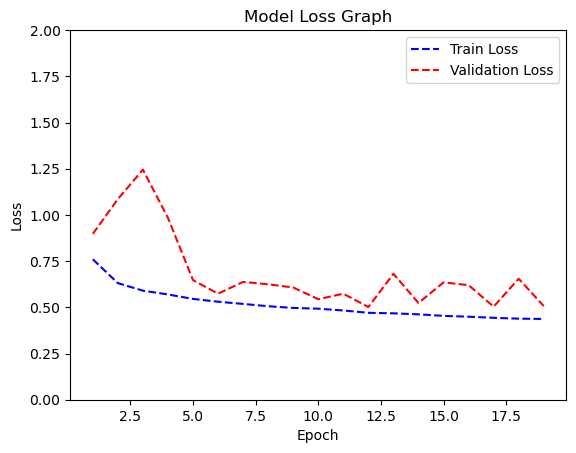

In [9]:
x_range = range(1, len(history.history["loss"]) + 1)
plt.plot(x_range, history.history["loss"], "b--", label="Train Loss")
plt.plot(x_range, history.history["val_loss"], "r--", label="Validation Loss")
plt.ylim((0, 2))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss Graph")
plt.legend()

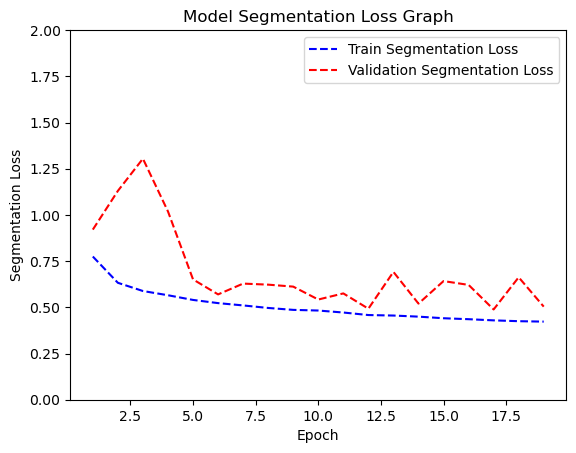

In [10]:
x_range = range(1, len(history.history["seg_loss"]) + 1)
plt.plot(x_range, history.history["seg_loss"], "b--", label="Train Segmentation Loss")
plt.plot(x_range, history.history["val_seg_loss"], "r--", label="Validation Segmentation Loss")
plt.ylim((0, 2))
plt.xlabel("Epoch")
plt.ylabel("Segmentation Loss")
plt.title("Model Segmentation Loss Graph")
plt.legend()

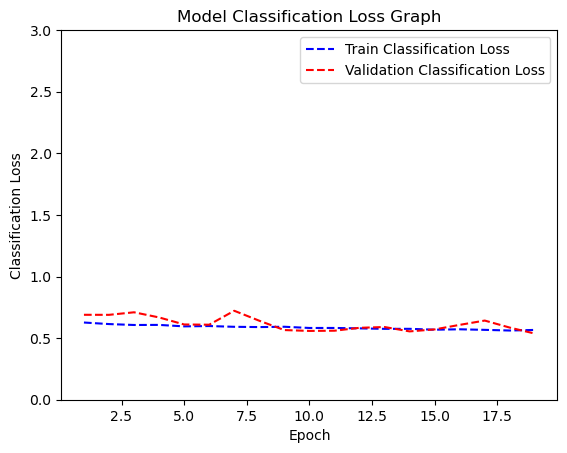

In [12]:
x_range = range(1, len(history.history["dense_loss"]) + 1)
plt.plot(x_range, history.history["dense_loss"], "b--", label="Train Classification Loss")
plt.plot(x_range, history.history["val_dense_loss"], "r--", label="Validation Classification Loss")
plt.ylim((0, 3))
plt.xlabel("Epoch")
plt.ylabel("Classification Loss")
plt.title("Model Classification Loss Graph")
plt.legend()

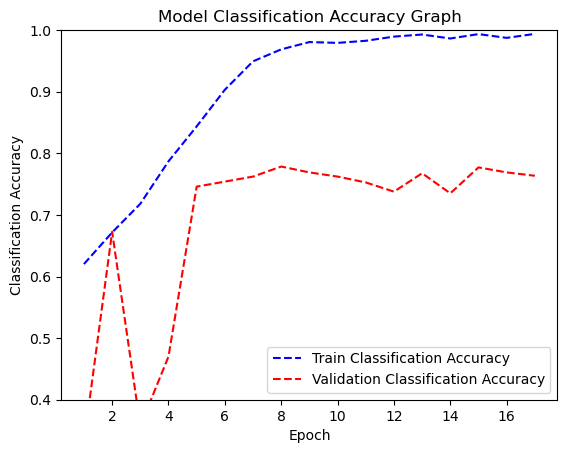

In [ ]:
x_range = range(1, len(history.history["clf_binary_accuracy"]) + 1)
plt.plot(x_range, history.history["clf_binary_accuracy"], "b--", label="Train Classification Accuracy")
plt.plot(x_range, history.history["val_clf_binary_accuracy"], "r--", label="Validation Classification Accuracy")
plt.ylim((0.4, 1))
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.title("Model Classification Accuracy Graph")
plt.legend()